Saving diabetes.csv to diabetes (8).csv

 Accuracy: 0.8010

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.72      0.80       106
           1       0.72      0.91      0.80        85

    accuracy                           0.80       191
   macro avg       0.81      0.81      0.80       191
weighted avg       0.82      0.80      0.80       191


Confusion Matrix:
           Predicted 0  Predicted 1
Actual 0           76           30
Actual 1            8           77


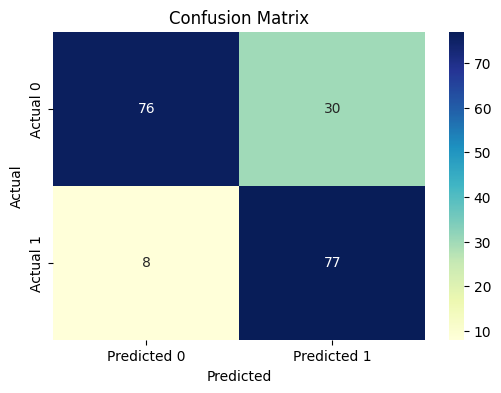


Detailed Metrics per Class:
 Class  Precision   Recall  F1-Score
     0   0.904762 0.716981  0.800000
     1   0.719626 0.905882  0.802083

ROC AUC Score: 0.8746
Matthews Correlation Coefficient (MCC): 0.6236
Cohen's Kappa Score: 0.6073


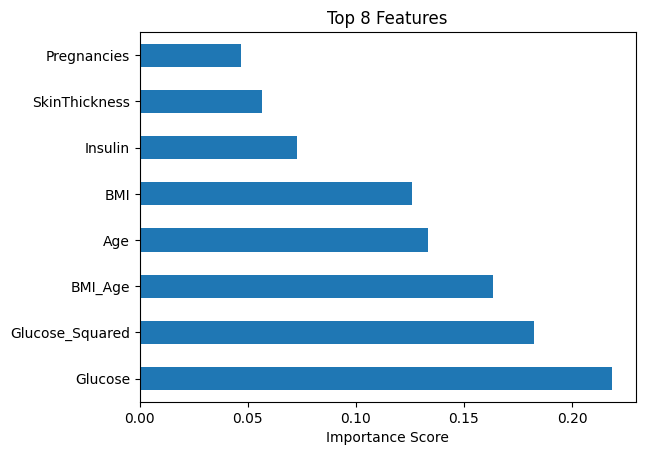

In [9]:
# STEP 1: Upload and Load Dataset
from google.colab import files
uploaded = files.upload()

import pandas as pd
import numpy as np

df = pd.read_csv('diabetes.csv')

#  STEP 2: Replace 0s with NaN
cols_with_zeroes = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zeroes] = df[cols_with_zeroes].replace(0, np.nan)
df.fillna(df.median(), inplace=True)

#  STEP 3: Outlier Removal using Z-score
from scipy import stats
df_clean = df[(np.abs(stats.zscore(df.select_dtypes(include=[np.number]))) < 3).all(axis=1)].copy()

#  STEP 4: Feature Engineering
df_clean.loc[:, 'BMI_Age'] = df_clean['BMI'] * df_clean['Age']
df_clean.loc[:, 'Glucose_Squared'] = df_clean['Glucose'] ** 2

df_clean.loc[:, 'Insulin'] = np.log1p(df_clean['Insulin'])
df_clean.loc[:, 'BMI'] = np.log1p(df_clean['BMI'])
df_clean.loc[:, 'Glucose_Squared'] = np.log1p(df_clean['Glucose_Squared'])

#  STEP 6: Features and Labels
X = df_clean.drop('Outcome', axis=1)
y = df_clean['Outcome']

#  STEP 7: Standardize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  STEP 8: Rebalance Using SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

#  STEP 9: Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(score_func=f_classif, k=8)
X_selected = selector.fit_transform(X_resampled, y_resampled)

#  STEP 10: Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_resampled, test_size=0.2, random_state=42)

#  STEP 11: Train Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf = RandomForestClassifier(n_estimators=150, max_depth=6, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]  # For ROC AUC

#  STEP 12: Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"\n Accuracy: {acc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

#  Detailed Metrics and Tables (no visuals)
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix as a DataFrame
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print("\nConfusion Matrix:\n", cm_df)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Per-class precision, recall, f1-score
precision_0 = precision_score(y_test, y_pred, pos_label=0)
recall_0 = recall_score(y_test, y_pred, pos_label=0)
f1_0 = f1_score(y_test, y_pred, pos_label=0)

precision_1 = precision_score(y_test, y_pred, pos_label=1)
recall_1 = recall_score(y_test, y_pred, pos_label=1)
f1_1 = f1_score(y_test, y_pred, pos_label=1)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_prob)

# Additional metrics
mcc = matthews_corrcoef(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

# Display detailed metrics in a table
metrics_df = pd.DataFrame({
    'Class': [0, 1],
    'Precision': [precision_0, precision_1],
    'Recall': [recall_0, recall_1],
    'F1-Score': [f1_0, f1_1]
})

print("\nDetailed Metrics per Class:")
print(metrics_df.to_string(index=False))

print(f"\nROC AUC Score: {roc_auc:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa Score: {kappa:.4f}")

#  Feature Importance Plot
feat_names = X.columns[selector.get_support()]
importances = pd.Series(rf.feature_importances_, index=feat_names)
importances.nlargest(8).plot(kind='barh', title='Top 8 Features')
plt.xlabel('Importance Score')
plt.show()